In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys
sys.path.insert(1, "../..")
from simulations import newtons_cooling_law
from itertools import product
from prototype_nn import Splitting, predictions, tensor_flatten
import matplotlib.pyplot as plt
import prototype
import torch
%run ../utilities.ipynb

## Training : Simulations

In [2]:
training = pd.DataFrame(data = pd.read_csv("../../data/train/newtons_cooling_law.csv", usecols=[0,1,2]))
training.head()

,time,temp,initial_temp
0,0,1.000000,1
1,1,1.312649,1
2,2,1.620644,1
3,3,1.924053,1
4,4,2.222945,1


### Dataframe

In [3]:
len(training)

12000

In [4]:
initial = training[training["initial_temp"] == 1]

<AxesSubplot:xlabel='time', ylabel='temp'>

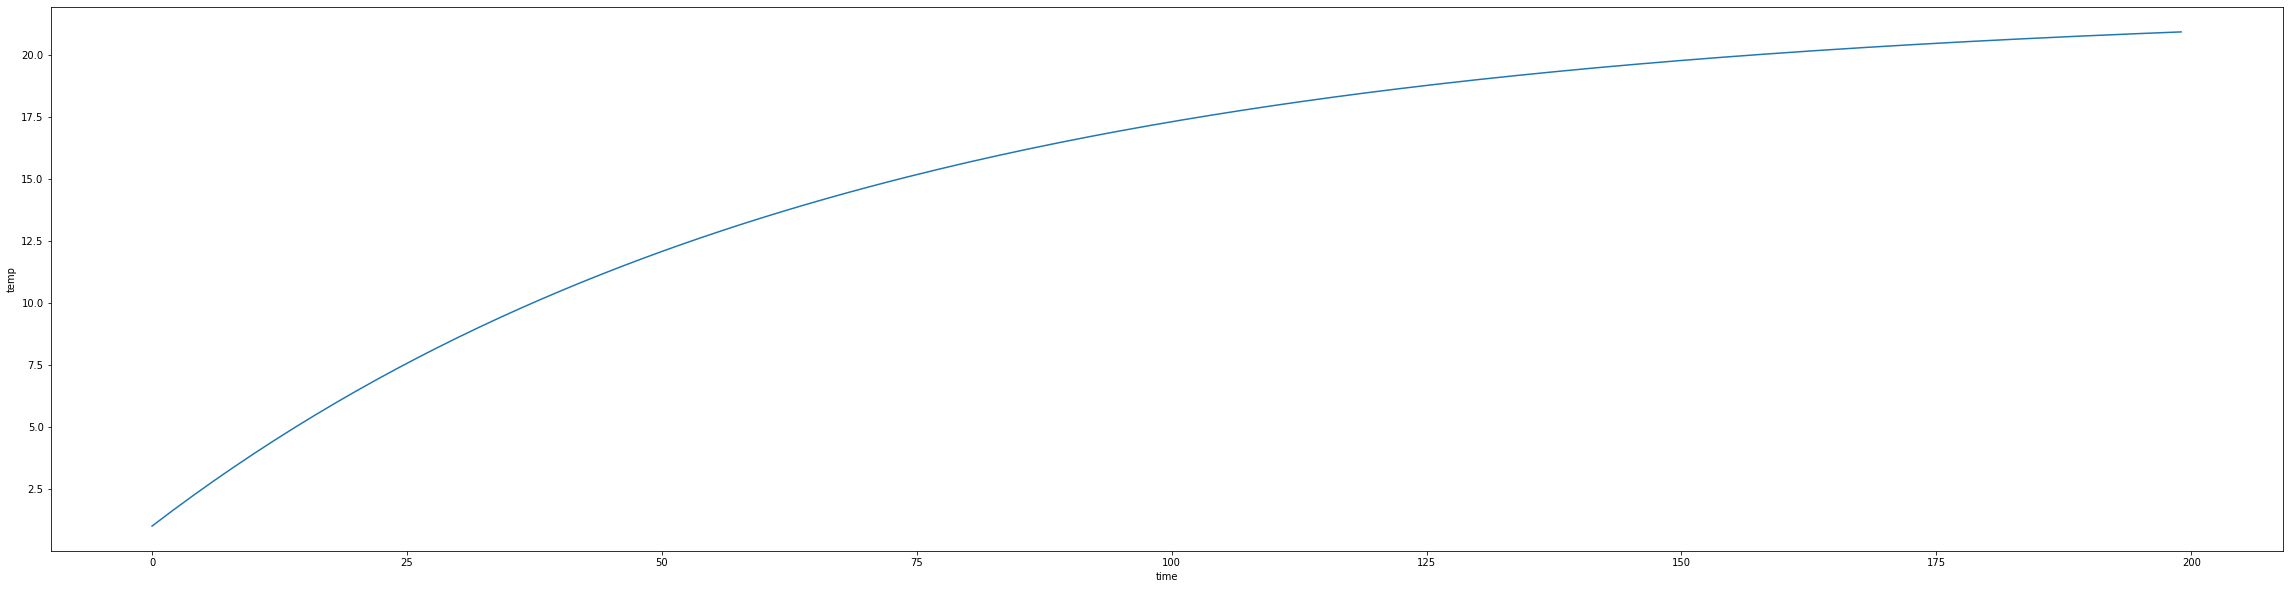

In [5]:
fig, ax = plt.subplots(ncols=1, figsize=(40,10))
sns.lineplot(data = initial, x = "time", y = "temp", ax=ax)

In [6]:
# lr = 0.0001, bs = 50, ts = 1, epoch = 20
kfold = Splitting([0,2], [1], num_epoches = 30, batch_size = 32, lr= 0.0001)

In [7]:
evaluate = kfold.cross_validation_evaluate(training, 5)

------------- Fold 0 -------------
TEST: 0 TRAIN: [1, 2, 3, 4]
Epoch: 0  Train Loss: 17.24005889892578 
Epoch: 1  Train Loss: 18.627567291259766 
Epoch: 2  Train Loss: 19.925142288208008 
Epoch: 3  Train Loss: 15.357797622680664 
Epoch: 4  Train Loss: 10.26101303100586 
Epoch: 5  Train Loss: 8.564998626708984 
Epoch: 6  Train Loss: 3.4249465465545654 
Epoch: 7  Train Loss: 2.232823371887207 
Epoch: 8  Train Loss: 0.9766983389854431 
Epoch: 9  Train Loss: 0.6871479749679565 
Epoch: 10  Train Loss: 0.2665480971336365 
Epoch: 11  Train Loss: 0.10038147866725922 
Epoch: 12  Train Loss: 0.0750335231423378 
Epoch: 13  Train Loss: 0.11663539707660675 
Epoch: 14  Train Loss: 0.07525023072957993 
Epoch: 15  Train Loss: 0.06782100349664688 
Epoch: 16  Train Loss: 0.0483316108584404 
Epoch: 17  Train Loss: 0.05384671688079834 
Epoch: 18  Train Loss: 0.01807761751115322 
Epoch: 19  Train Loss: 0.02807682752609253 
Epoch: 20  Train Loss: 0.011013828217983246 
Epoch: 21  Train Loss: 0.01990194432437

In [8]:
evaluate

[tensor(0.0780, grad_fn=<MseLossBackward>),
 tensor(0.0092, grad_fn=<MseLossBackward>),
 tensor(0.0365, grad_fn=<MseLossBackward>),
 tensor(0.0146, grad_fn=<MseLossBackward>),
 tensor(0.0486, grad_fn=<MseLossBackward>)]

In [9]:
average_loss = 0
for x in evaluate:
    average_loss += x.item()
average_loss/len(evaluate)

0.037401994504034516

## Training_set : Predictions

In [6]:
training_predictions = pd.DataFrame(data=pd.read_csv("../../data/preds/train/newtons_cooling_law.csv"))
training_predictions.head()

,initial_temp,time,temp
0,1,0,1.017763
1,1,1,1.297256
2,1,2,1.475456
3,1,3,1.974566
4,1,4,2.364241


In [7]:
training_predictions = training_predictions.rename(columns = {"temp" : "preds_temps"})

In [8]:
training_predictions.head()

,initial_temp,time,preds_temps
0,1,0,1.017763
1,1,1,1.297256
2,1,2,1.475456
3,1,3,1.974566
4,1,4,2.364241


In [9]:
training_and_predictions = training_predictions.merge(training.drop(columns = ["time", "initial_temp"]), right_index = True, left_index = True)

In [10]:
training_and_predictions.head()

,initial_temp,time,preds_temps,temp
0,1,0,1.017763,1.000000
1,1,1,1.297256,1.312649
2,1,2,1.475456,1.620644
3,1,3,1.974566,1.924053
4,1,4,2.364241,2.222945


In [11]:
def hue(df):
    columns = list(df.columns)
    columns.remove("temp")
    columns.remove("preds_temps")
    df = df.melt(columns, var_name='preds/simulations', value_name='temps')
    return df

## Graphs

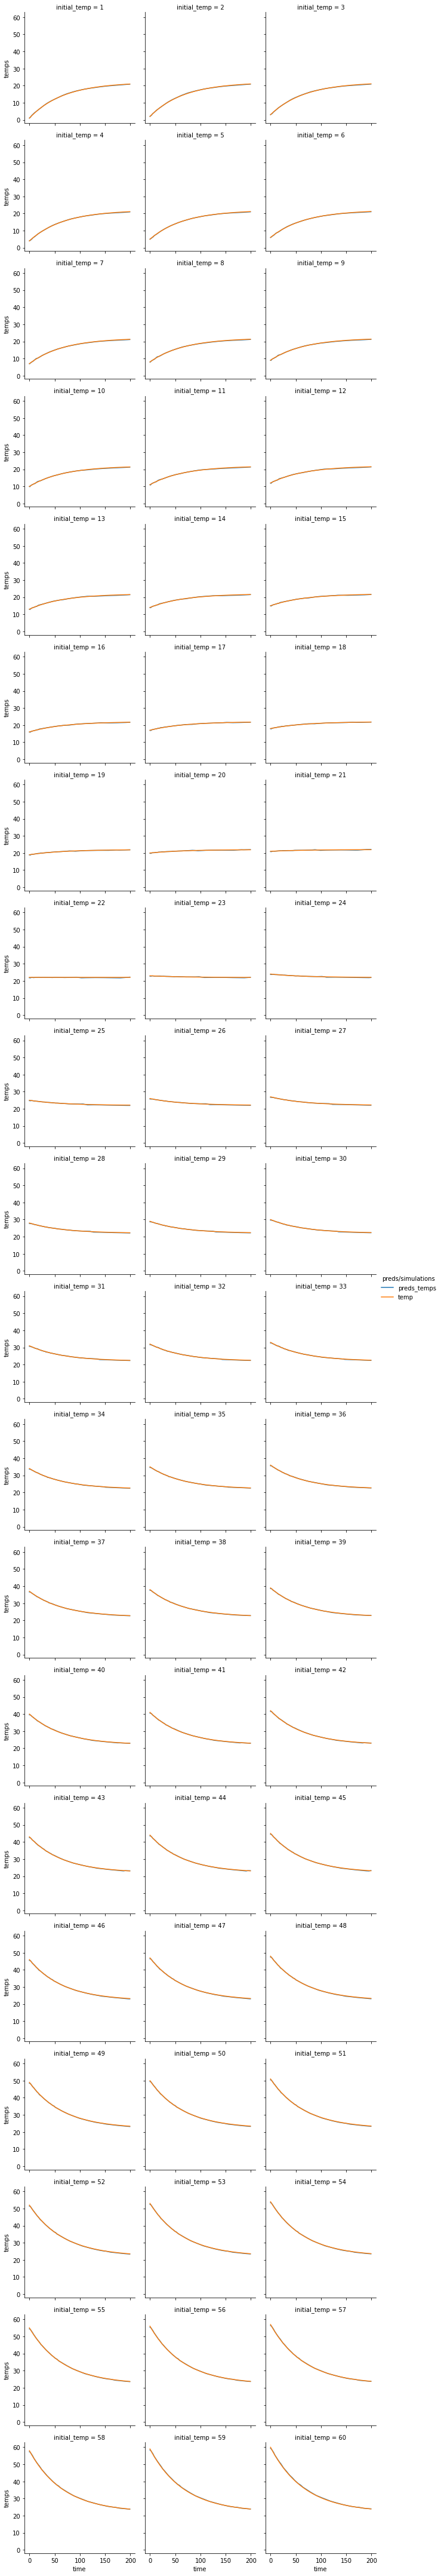

In [12]:
g = sns.FacetGrid(hue(training_and_predictions), col="initial_temp", hue = "preds/simulations", col_wrap=3,)
g.map(sns.lineplot, "time", "temps", ci=None)
g.add_legend()

## Testing : Simulations

In [137]:
testing = newtons_cooling_law(delta = 1, simulations = 200 , save = False, initial_paras = np.random.uniform(0, 65, 100))

In [138]:
testing.head()

,time,temp,initial_temp
0,0,10.551601,10.551601
1,1,10.722046,10.551601
2,2,10.889952,10.551601
3,3,11.055359,10.551601
4,4,11.218304,10.551601


In [139]:
len(testing)

20000

In [140]:
def testing_preds(test_df):
    inputs = torch.tensor(test_df.iloc[ :, [0,2]].values)
    targets = torch.tensor(test_df.iloc[:, [1]].values)
    preds, _ = predictions(num_inputs=2, num_classes=1, learning_rate=0.0005, batch_size=1, num_epochs=1, inputs=inputs.float(), targets=targets.float(), train=False, path= "../../data/state/newtons_cooling_law.pth")
    data = {'time' : test_df.time.values,
            'initial_temp' : test_df.initial_temp.values,
            'temp' : tensor_flatten(preds[:,0])}
    return pd.DataFrame(data = data, columns = ["time", "temp", "initial_temp"]);

In [141]:
testing_predictions = testing_preds(testing)
testing_predictions = testing_predictions.rename(columns = {"temp" : "preds_temps"})

In [142]:
testing_predictions.head()

,time,preds_temps,initial_temp
0,0,10.501188,10.551601
1,1,10.361059,10.551601
2,2,10.750355,10.551601
3,3,11.091357,10.551601
4,4,11.299452,10.551601


In [143]:
len(testing_predictions)

20000

In [144]:
testing_and_predictions = testing.merge(testing_predictions, right_on = ["time", "initial_temp"], left_on = ["time", "initial_temp"])
#training_and_predictions = training_predictions.merge(training.drop(columns = ["time", "initial_temp"]), right_index = True, left_index = True)

In [145]:
testing_and_predictions.head()

,time,temp,initial_temp,preds_temps
0,0,10.551601,10.551601,10.501188
1,1,10.722046,10.551601,10.361059
2,2,10.889952,10.551601,10.750355
3,3,11.055359,10.551601,11.091357
4,4,11.218304,10.551601,11.299452


In [146]:
len(testing_and_predictions)

20000

## Graphs

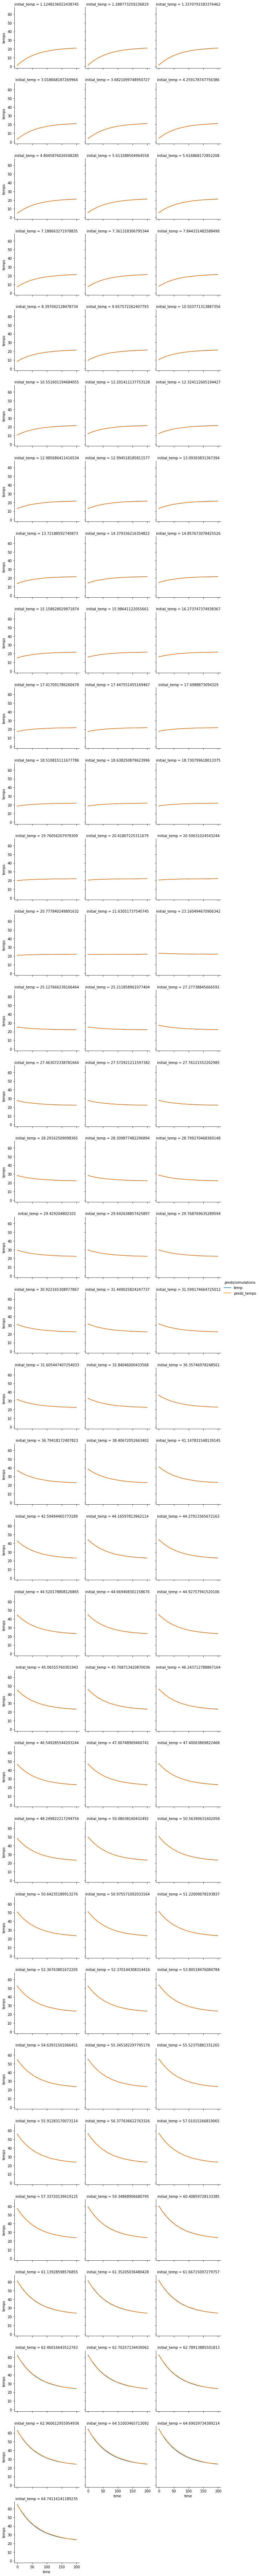

In [206]:
g = sns.FacetGrid(hue(testing_and_predictions), col="initial_temp", hue = "preds/simulations", col_wrap=3,)
g.map(sns.lineplot, "time", "temps", ci=None)
g.add_legend()

### Loss by simulation

This section is looking at the loss for each simulation

In [159]:
testing_cpy = testing

In [160]:
testing_predictions_cpy = testing_predictions

These are the dataframes we are using:
    <ol>
    <li> testing_cpy - holds the testing simulation data </li>
    <li> testing_predictions_cpy - hold the prediction fo the testing simulation data </li>
    </ol>

In [161]:
testing_cpy['initial_parameters'] = list(zip(testing_cpy.initial_temp))
testing_predictions_cpy['initial_parameters'] = list(zip(testing_predictions_cpy.initial_temp))

In [162]:
testing_cpy.head()

,time,temp,initial_temp,initial_parameters
0,0,10.551601,10.551601,"(10.551601194684055,)"
1,1,10.722046,10.551601,"(10.551601194684055,)"
2,2,10.889952,10.551601,"(10.551601194684055,)"
3,3,11.055359,10.551601,"(10.551601194684055,)"
4,4,11.218304,10.551601,"(10.551601194684055,)"


In [163]:
testing_predictions_cpy.head()

,time,preds_temps,initial_temp,initial_parameters
0,0,10.501188,10.551601,"(10.551601194684055,)"
1,1,10.361059,10.551601,"(10.551601194684055,)"
2,2,10.750355,10.551601,"(10.551601194684055,)"
3,3,11.091357,10.551601,"(10.551601194684055,)"
4,4,11.299452,10.551601,"(10.551601194684055,)"


The lossBySimulation function provides us with a loss for each individual simulation

In [165]:
simulationLoss, _ = lossBySimulations(testing, testing_predictions, [1,2])

In [187]:
simulationLossDistance = lossBySimulationsDistance(simulationLoss, initial_values = [np.arange(1,65,1)])

In [188]:
simulationLossDistance.head()

,initial_parameters,Loss,Distance
55,32.84046000433568,0.003749,0.340460
54,31.605447407254033,0.004299,0.894553
53,31.599174664725012,0.004302,0.900825
52,31.449025824247737,0.004343,1.050974
51,30.922165308977867,0.004543,1.577835


This is the simulationLoss is dataframe showing the simulation and the correpsonding loss

In [189]:
simulationLoss.head()

,initial_parameters,Loss,Distance
0,1.1248236022438745,0.006625,31.375176
1,1.288773259236819,0.006922,31.211227
2,1.3370791583376462,0.006999,31.162921
3,3.018668187269964,0.006651,29.481332
4,3.6821099748950727,0.005766,28.817890


In [190]:
len(simulationLoss)

100

In [191]:
len(simulationLossDistance)

100

This is demonstrating the graph for each simulation

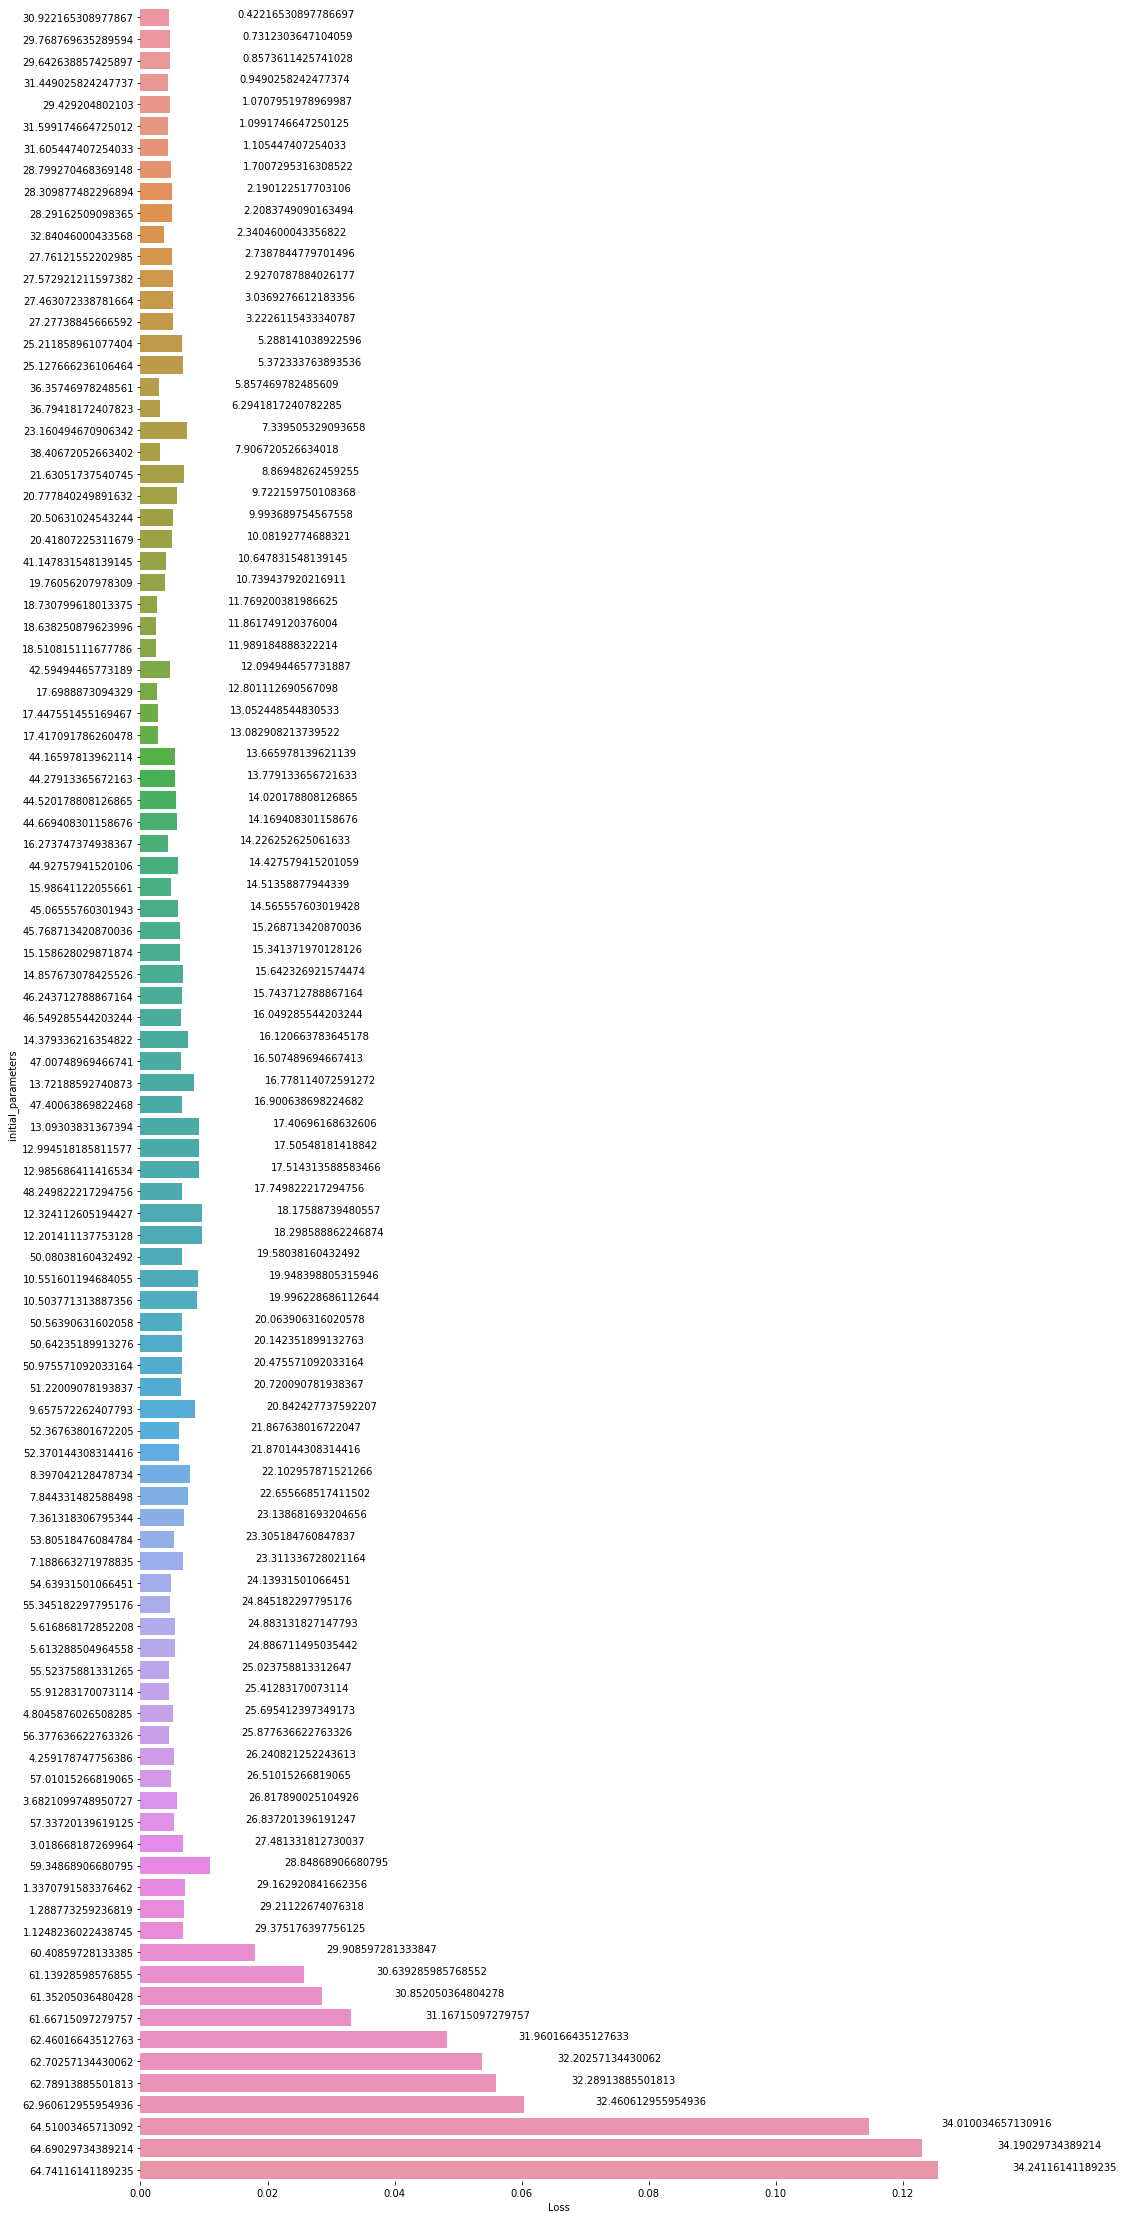

In [175]:
simulaPlots("Loss", "initial_parameters", simulationLossDistance, figsize = (15, 40), pos = 0.02)

This lossByTime function has the loss at each individual time within a simulation

<AxesSubplot:>

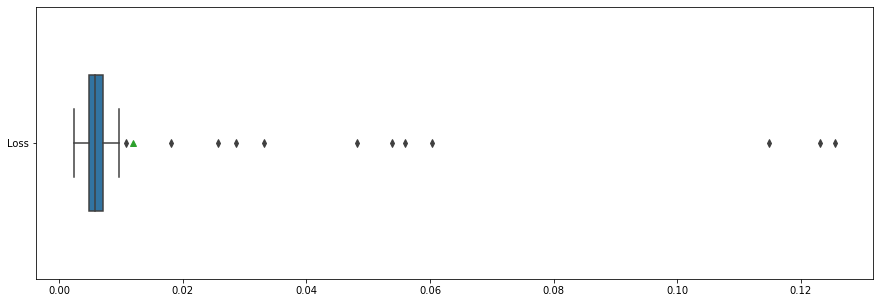

In [208]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data = simulationLossDistance[["Loss"]], showmeans=True, orient="h", width = 0.5, ax=ax)

In [201]:
len(simulationLossDistance)

100

In [202]:
timeLoss, _ = lossByTime(testing_cpy, testing_predictions_cpy, [1])

This timeLoss dataframe shows the loss corresponding to an individual time step for a specified simulation

In [203]:
timeLoss.head()

,Time,initial_parameters,Loss
0,0,"(1.1248236022438745,)",0.000310
1,1,"(1.1248236022438745,)",0.002992
2,2,"(1.1248236022438745,)",0.034138
3,3,"(1.1248236022438745,)",0.000253
4,4,"(1.1248236022438745,)",0.010618


In [204]:
individualTimeLoss = timeLoss.groupby("Time").mean("Loss").reset_index()

This data is shown on a graphs

<AxesSubplot:xlabel='Time', ylabel='Loss'>

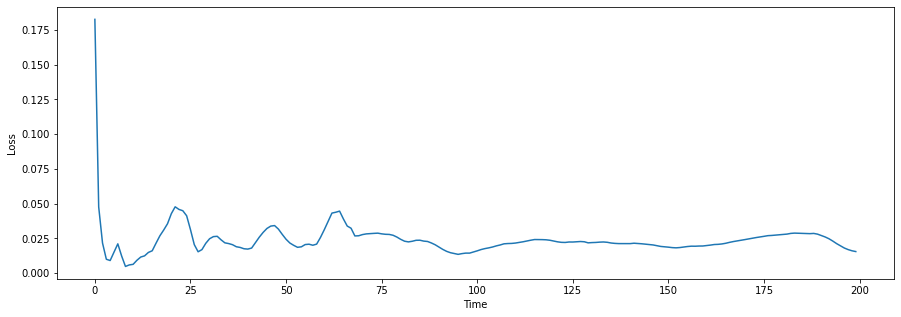

In [207]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data = individualTimeLoss, x = "Time", y = "Loss", ax=ax)